Monolayer unit domain. Piecewise PML. Convergence (eigenvalue error)

In [18]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType, KSP
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


In [19]:
# dolfinx.__version__

Domain, PML, refinement and physical configurations

In [ ]:
# Define element size for the mesh refinement
h_i = [0.125,
    0.0625,
    0.0625 / 2,
    0.0625 / 4,]
    # 0.0625 / 8,]


# Domain configuration
Lx = 1 # fluid domain length (without PML)

# Physical configuration
rho_media_1 = 1 # kg/m^3 
vel_media_1 = 1   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return rho_media_1+x[0]*0
def vel_function(x):    
    return vel_media_1+x[0]*0
 
# PML configuration
pml_thickness = Lx/4
sigma_0 = 2.  #100/Lx

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [21]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    # solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 1000)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-2.5j)  
    solver.solve()
    n_eigs_converged_piecewise = solver.getConverged()
    
    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [22]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof, exact_value):
    from numpy import abs

    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real maior que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))

    if not (0 <= selected_index < len(eigenvalues)):
        raise IndexError("selected_index fóra de rango dos eigenvalores filtrados")

    # Comprobación do máis próximo ao exacto nun rango de ±5
    i_min = max(0, selected_index - 5)
    i_max = min(len(eigenvalues), selected_index + 6)

    closest_idx = min(
        range(i_min, i_max),
        key=lambda i: abs(eigenvalues[i][0] - exact_value)
    )

    if closest_idx != selected_index:
        print(f"Aviso: o índice {selected_index} non é o máis próximo ao valor exacto.")
        print(f"O máis próximo é o índice {closest_idx} con valor {eigenvalues[closest_idx][0]}")
    # else:
        # print("O índice seleccionado é o máis próximo ao valor exacto.")

    # Seleccionar o autovalor e vector correspondente
    omega_value, vrA = eigenvalues[closest_idx]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] /= p_h.eval([Lx, 0.0, 0.0], 1)  # normalizar
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] /= v_h.eval([Lx, 0.0, 0.0], 1)  # normalizar

    return [omega_value, p_h, v_h]


piecewise

In [23]:
get_exact_pml_eigenvalue=lambda n: ((n+1) * np.pi * vel_media_1 - 1j * pml_thickness*sigma_0) / (Lx + pml_thickness)

exact = [None] * 5 
for j in np.arange(0, 5,1):
    exact[j] = get_exact_pml_eigenvalue(j)


In [24]:
# Define piecewise sigma function
sigma_x_piecewise=lambda x: conditional(x[0] > Lx, sigma_0, 0.0)
# Initialize lists to store the approximated eigenpairs
approx_piecewise_P1_P0 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P2_P1 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P3_P2 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P4_P3 = [[0 for _ in range(5)] for _ in range(len(h_i))]

for i,h in enumerate(h_i):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
    # Define solver for piecewise PML
    [solver_piecewise_P1_P0, mesh, Q_P1_P0, V_P1_P0, dof_P1_P0]=get_configured_problem(mesh, [1,0], sigma_x_piecewise)
    [solver_piecewise_P2_P1, mesh, Q_P2_P1, V_P2_P1, dof_P2_P1]=get_configured_problem(mesh, [2,1], sigma_x_piecewise)
    [solver_piecewise_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_x_piecewise)
    [solver_piecewise_P4_P3, mesh, Q_P4_P3, V_P4_P3, dof_P4_P3]=get_configured_problem(mesh, [4,3], sigma_x_piecewise)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_piecewise_P1_P0[i][j] = get_approx_eigenpair(solver_piecewise_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0, exact[j])[0]
        approx_piecewise_P2_P1[i][j] = get_approx_eigenpair(solver_piecewise_P2_P1, j, Q_P2_P1, V_P2_P1, dof_P2_P1, exact[j])[0]
        approx_piecewise_P3_P2[i][j] = get_approx_eigenpair(solver_piecewise_P3_P2, j, Q_P3_P2, V_P3_P2, dof_P3_P2, exact[j])[0]
        approx_piecewise_P4_P3[i][j] = get_approx_eigenpair(solver_piecewise_P4_P3, j, Q_P4_P3, V_P4_P3, dof_P4_P3, exact[j])[0]


In [25]:
def agrupar_por_posicion(lista_de_listas):
    return [list(grupo) for grupo in zip(*lista_de_listas)]

def borrar_filas_incompletas(lista_de_listas, longitud_minima):
    return [fila for fila in lista_de_listas if len(fila) >= longitud_minima]

# Uso de la función
longitud_minima = len(h_i)
groups_P1_P0=agrupar_por_posicion(approx_piecewise_P1_P0)
groups_P2_P1=agrupar_por_posicion(approx_piecewise_P2_P1)
groups_P3_P2=agrupar_por_posicion(approx_piecewise_P3_P2)
groups_P4_P3=agrupar_por_posicion(approx_piecewise_P4_P3)

groups_P1_P0 = borrar_filas_incompletas(groups_P1_P0, longitud_minima)
groups_P2_P1 = borrar_filas_incompletas(groups_P2_P1, longitud_minima)
groups_P3_P2 = borrar_filas_incompletas(groups_P3_P2, longitud_minima)
groups_P4_P3 = borrar_filas_incompletas(groups_P4_P3, longitud_minima)

In [26]:
rel_error_eig_0_P1_P0=abs((groups_P1_P0[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P1_P0=abs((groups_P1_P0[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P1_P0=abs((groups_P1_P0[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P1_P0=abs((groups_P1_P0[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P2_P1=abs((groups_P2_P1[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P2_P1=abs((groups_P2_P1[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P2_P1=abs((groups_P2_P1[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P2_P1=abs((groups_P2_P1[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P3_P2=abs((groups_P3_P2[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P3_P2=abs((groups_P3_P2[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P3_P2=abs((groups_P3_P2[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P3_P2=abs((groups_P3_P2[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P4_P3=abs((groups_P4_P3[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P4_P3=abs((groups_P4_P3[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P4_P3=abs((groups_P4_P3[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P4_P3=abs((groups_P4_P3[3] - exact[3])) / np.abs(exact[3]) 


In [27]:
print("P1-P0:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P1_P0[idx][-1]}")
    error = abs(groups_P1_P0[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P1-P0:
Autovalor 0:
  Exacto:      (2.792526803190927-0.2222222222222222j)
  Aproximado:  (2.7927423991139153-0.2222592478333835j)
  Error rel.:  7.808798041693228e-05

Autovalor 1:
  Exacto:      (5.585053606381854-0.2222222222222222j)
  Aproximado:  (5.586782070920858-0.2223369462420587j)
  Error rel.:  0.0003099161080369909

Autovalor 2:
  Exacto:      (8.377580409572781-0.2222222222222222j)
  Aproximado:  (8.383440782617102-0.2223765345213381j)
  Error rel.:  0.0006995269133420322

Autovalor 3:
  Exacto:      (11.170107212763709-0.2222222222222222j)
  Aproximado:  (11.184074109790988-0.22231088688431835j)
  Error rel.:  0.0012501594660831335

Autovalor 4:
  Exacto:      (13.962634015954634-0.2222222222222222j)
  Aproximado:  (13.99005913930927-0.22213815998160238j)
  Error rel.:  0.0019639402827466373



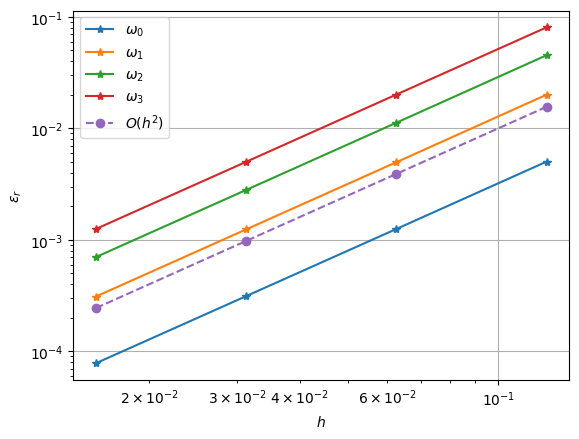

In [28]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P1_P0, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P1_P0, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P1_P0, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P1_P0, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**2 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{2}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
# plt.title(f"[P{problem.FE['p']._degree}-P{problem.FE['v']._degree}] - PML eigenvalues' convergence. {pml_type} profile.")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

In [29]:
print("P2-P1:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P2_P1[idx][-1]}")
    error = abs(groups_P2_P1[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P2-P1:
Autovalor 0:
  Exacto:      (2.792526803190927-0.2222222222222222j)
  Aproximado:  (2.792526804815921-0.2222222235527714j)
  Error rel.:  7.49719417872816e-10

Autovalor 1:
  Exacto:      (5.585053606381854-0.2222222222222222j)
  Aproximado:  (5.5850537907525215-0.2222222056055576j)
  Error rel.:  3.311903617741452e-08

Autovalor 2:
  Exacto:      (8.377580409572781-0.2222222222222222j)
  Aproximado:  (8.377582018309761-0.22222215508358642j)
  Error rel.:  1.921284073053511e-07

Autovalor 3:
  Exacto:      (11.170107212763709-0.2222222222222222j)
  Aproximado:  (11.170114245291185-0.22222215937313583j)
  Error rel.:  6.294851826112643e-07

Autovalor 4:
  Exacto:      (13.962634015954634-0.2222222222222222j)
  Aproximado:  (13.962655684879323-0.22222239178318043j)
  Error rel.:  1.5517734048551833e-06



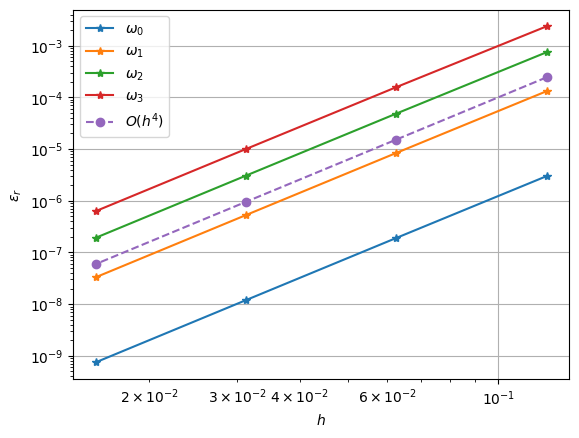

In [30]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P2_P1, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P2_P1, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P2_P1, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P2_P1, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**4 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{4}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()


In [31]:
print("P3-P2:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P3_P2[idx][-1]}")
    error = abs(groups_P3_P2[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P3-P2:
Autovalor 0:
  Exacto:      (2.792526803190927-0.2222222222222222j)
  Aproximado:  (2.792526803190095-0.22222222222231075j)
  Error rel.:  2.98755385479222e-13

Autovalor 1:
  Exacto:      (5.585053606381854-0.2222222222222222j)
  Aproximado:  (5.585053606391978-0.222222222225098j)
  Error rel.:  1.8828246870038117e-12

Autovalor 2:
  Exacto:      (8.377580409572781-0.2222222222222222j)
  Aproximado:  (8.377580409761428-0.22222222224435031j)
  Error rel.:  2.2664527158216527e-11

Autovalor 3:
  Exacto:      (11.170107212763709-0.2222222222222222j)
  Aproximado:  (11.170107214209205-0.22222222227912272j)
  Error rel.:  1.2948214658888512e-10

Autovalor 4:
  Exacto:      (13.962634015954634-0.2222222222222222j)
  Aproximado:  (13.96263402299438-0.2222222222309493j)
  Error rel.:  5.041211252176741e-10



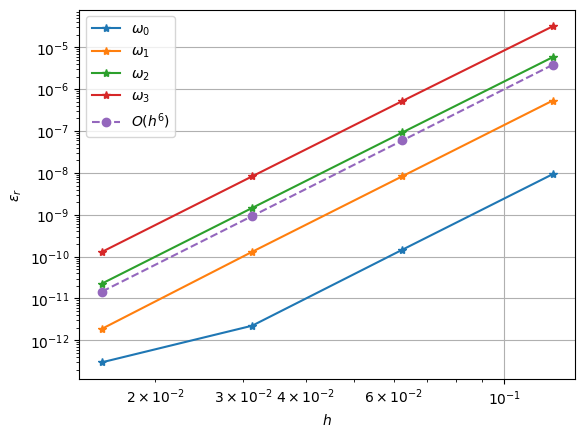

In [32]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P3_P2, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P3_P2, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P3_P2, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P3_P2, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**6 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{6}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()

In [33]:
print("P4-P3:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P4_P3[idx][-1]}")
    error = abs(groups_P4_P3[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P4-P3:
Autovalor 0:
  Exacto:      (2.792526803190927-0.2222222222222222j)
  Aproximado:  (2.79252680318748-0.22222222222244167j)
  Error rel.:  1.232974751740537e-12

Autovalor 1:
  Exacto:      (5.585053606381854-0.2222222222222222j)
  Aproximado:  (5.5850536063784455-0.222222222222211j)
  Error rel.:  6.098691812466602e-13

Autovalor 2:
  Exacto:      (8.377580409572781-0.2222222222222222j)
  Aproximado:  (8.377580409569477-0.22222222222208046j)
  Error rel.:  3.946127541625596e-13

Autovalor 3:
  Exacto:      (11.170107212763709-0.2222222222222222j)
  Aproximado:  (11.170107212760708-0.22222222222199098j)
  Error rel.:  2.6934108096587983e-13

Autovalor 4:
  Exacto:      (13.962634015954634-0.2222222222222222j)
  Aproximado:  (13.96263401595283-0.2222222222219554j)
  Error rel.:  1.3064609002216047e-13



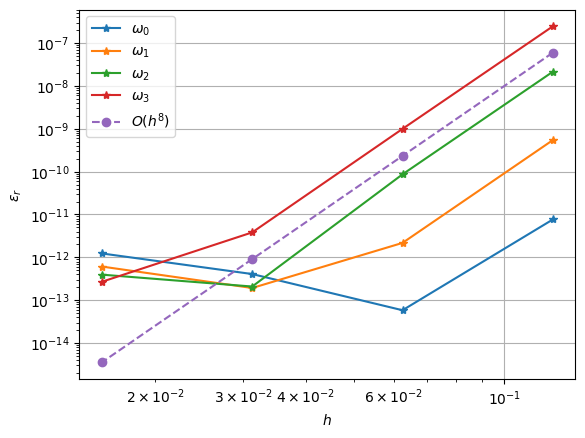

In [34]:
fig = plt.figure()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.plot(h_i, rel_error_eig_0_P4_P3, "*-", label='$\omega_0$')
plt.plot(h_i, rel_error_eig_1_P4_P3, "*-", label='$\omega_1$')
plt.plot(h_i, rel_error_eig_2_P4_P3, "*-", label='$\omega_2$')
plt.plot(h_i, rel_error_eig_3_P4_P3, "*-", label='$\omega_3$')
plt.plot(
    h_i,
    [x**8 for x in h_i],
    linestyle="--",
    marker="o",
    label=f"$O(h^{{{8}}})$",
)
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$h$")
_ = plt.ylabel("$\epsilon_r$")
plt.legend()